<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/AMAZON%20CHRONOS/Amazon_Chronos_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AMAZON CHRONOS

It is a suite of pretrained models for timeseries forecasting, treating time series data like a language models treat text.

Chronos converts time series data into tokens, leveraging LLMs to handle complex patterns and deliver accurate forecasts.

**What is a token?**

It is a piece of text data in language models. Token can be small or large.
- Example: "Amazon Chronos is powerful" -> ["Amazon", "Chronos", "is", "powerful"]

In amazon chronos time series forecasting, we deal with numerical data points. Chronos treats each data point as a token, scaling and quantizing them into a fixed vocabulary representing data ranges or states.
- Example: TS of daily temperatures [72, 75, 78, 76, 73]

**How does Amazon Chronos work?**

Chronos transforms time series data into tokens using scaling and quantization. These tokens are then processed by a language model, typically based on the T5 architecture but adapted for time series data.
1. Tokenization: ts values are scaled and quantized into discrete tokens for model processing
2. Training: Tokenized data is fed into a language model, which predicts the next token using cross-entropy loss.
3. Inference: the model generates probabilistic forecast, offering multiple future trajectories based on historical data.

**Understanding the T5 Architecture**

T5 (Text to Text Transfer Transformer) model is a transformer architecture developed by google. It treats every NLP as text-to-text problem. Input and outputs are text strings, streamlining training across tasks without altering the model architecture.

**How does the T5 architecture works?**

1. Encoder-Decoder Structure: The encoder compresses the input sequence into context, and decoder generates output sequence
2. Pretraining: Pretraining enchances its broad language understanding capabilities.
3. Fine-tuning: T5 can be fined-tunes for tasks like Amazon Chronos, adapting it to process time series data as token sequences.

**Pros:**
1. High Accuracy in Forecasting
2. Versatility and Generation (Zero Shot Learning)
3. Simplified Forecasting Process

**Limitations:**
1. Lack of support  for covariates. We just have timeseries as an input.
2. No multiple ts forecasting
3. Computational Intensity
4. New and Less Documented
5. Complexity of Model Interpretability.


### SET-UP

In [ ]:
# Install the chronos library and time series database
!pip install -q git+https://github.com/amazon-science/chronos-forecasting.git
!pip install -q tsdb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

import tsdb
from chronos import ChronosPipeline
from datetime  import datetime
import torch
import random

2025-09-23 08:03:30 [WARNING]: ‼️ PyPOTS Ecosystem configuration file does not exist.
2025-09-23 08:03:30 [INFO]: Wrote new configs to config.ini successfully.
2025-09-23 08:03:30 [INFO]: 💫 Initialized PyPOTS Ecosystem configuration file /root/.pypots/config.ini successfully.


In [ ]:
# Load Beijing Air Quality data from tsdb
df = pd.DataFrame(tsdb.load('beijing_multisite_air_quality')['X'])
df.head()

2025-09-23 08:04:08 [INFO]: You're using dataset beijing_multisite_air_quality, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/beijing_multisite_air_quality
2025-09-23 08:04:08 [INFO]: Start downloading...
2025-09-23 08:04:08 [INFO]: Successfully downloaded data to /tmp/tmpi58dtm6m/PRSA2017_Data_20130301-20170228.zip
2025-09-23 08:04:08 [INFO]: Successfully extracted data to /root/.pypots/tsdb/beijing_multisite_air_quality
2025-09-23 08:04:08 [INFO]: Reading /root/.pypots/tsdb/beijing_multisite_air_quality/PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv, data shape (35064, 18)
2025-09-23 08:04:08 [INFO]: Reading /root/.pypots/tsdb/beijing_multisite_air_quality/PRSA_Data_20130301-20170228/PRSA_Data_Shunyi_20130301-20170228.csv, data shape (35064, 18)
2025-09-23 08:04:08 [INFO]: Reading /root/.pypots/tsdb/beijing_multisite_air_quality/PRSA_Data_20130301-201702

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 61.0+ MB


In [ ]:
# Rename temp as y
df = df.rename(columns = {'TEMP': 'y'})
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,y,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [ ]:
# Creta function to create a datetime format
def clean_datetime(df):
  dttime = str(df['year']) + "-" + str(df['month']) + "-" + str(df['day']) + " " + str(df['hour']) + ":00:00"
  return datetime.strptime(dttime, '%Y-%m-%d %H:%M:%S')


# Create ds and apply function
df['ds'] = df.apply(clean_datetime, axis = 1)
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,y,PRES,DEWP,RAIN,wd,WSPM,station,ds
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng,2013-03-01 00:00:00
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng,2013-03-01 01:00:00
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng,2013-03-01 03:00:00
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng,2013-03-01 04:00:00


In [ ]:
df['ds'].dtype

dtype('<M8[ns]')

In [ ]:
# Set ds as index
df = df.set_index('ds')

In [ ]:
df.index

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00',
               '2013-03-01 02:00:00', '2013-03-01 03:00:00',
               '2013-03-01 04:00:00', '2013-03-01 05:00:00',
               '2013-03-01 06:00:00', '2013-03-01 07:00:00',
               '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00',
               '2017-02-28 16:00:00', '2017-02-28 17:00:00',
               '2017-02-28 18:00:00', '2017-02-28 19:00:00',
               '2017-02-28 20:00:00', '2017-02-28 21:00:00',
               '2017-02-28 22:00:00', '2017-02-28 23:00:00'],
              dtype='datetime64[ns]', name='ds', length=420768, freq=None)

In [ ]:
# Filter the dataframe to include only the data from the 'Wanliu' station and select the 'y' column
df = df.loc[df["station"] == "Wanliu"]["y"]
df.head()

,y
ds,
2013-03-01 00:00:00,-0.7
2013-03-01 01:00:00,-1.1
2013-03-01 02:00:00,-1.1
2013-03-01 03:00:00,-1.4
2013-03-01 04:00:00,-2.0


In [ ]:
# Set the frequency to hourly
df = df.asfreq("H")

/tmp/ipython-input-3586686801.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("H")


### EDA

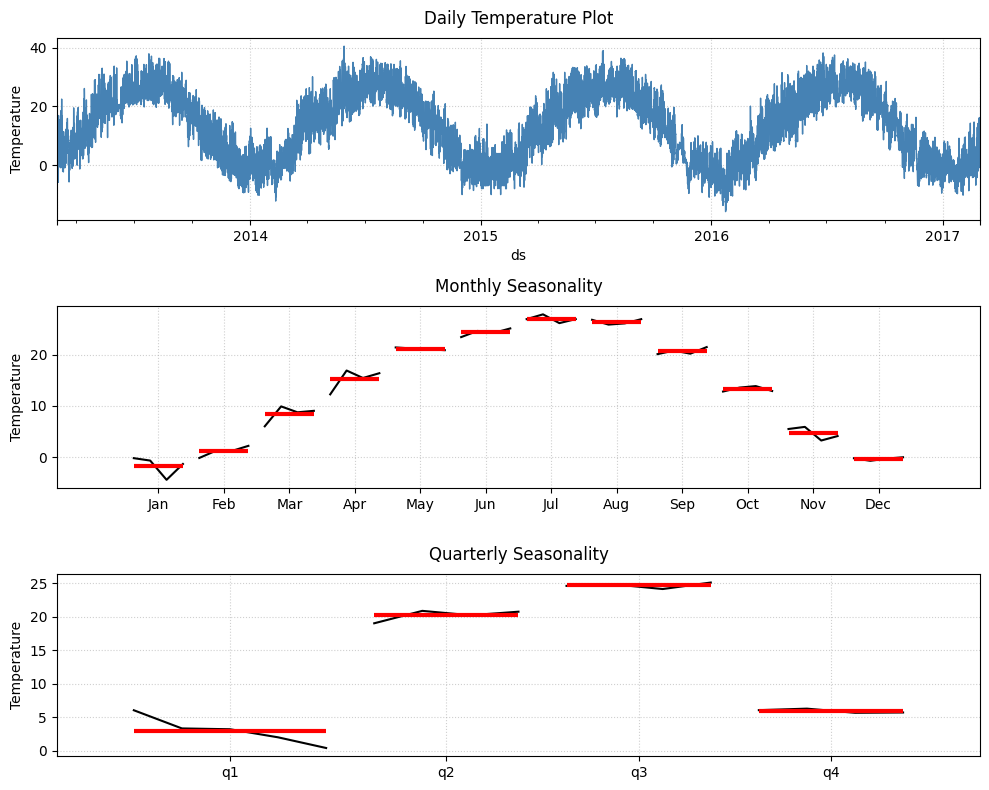

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Daily Plot
df.plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Daily Temperature Plot', fontsize=12, pad=10)
ax1.set_ylabel('Temperature', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)

# Monthly Seasonality Plot
month_plot(df.resample('ME').mean(), ylabel='Demand', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('Temperature', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df.resample('QE').mean(), ylabel='Demand', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('Temperature', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

### Amazon Chronos Model

In [ ]:
# Start a pipeline from the pretrained model using ChronosPipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
# Print the documentation for the 'predict' method in ChronosPipeline
print(ChronosPipeline.predict.__doc__)


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

In [ ]:
# Build the forecast using the ChronosPipeline's predict method
forecast = pipeline.predict(
    context=torch.tensor(df),          # Pass the time series data as a tensor
    temperature=1.0,                   # Set the sampling temperature for prediction
    top_k=50,                          # Limit the number of highest probability vocabulary tokens to keep for top-k-filtering
    top_p=1.0,                         # Set the cumulative probability for nucleus sampling
    prediction_length=72,              # Define the number of steps to predict into the future THIS SHOULD BE LESS THAN/EQUAL TO 64. BUT YOU CAN PASS ALLOW PREIDICTION LENGTH TO FALSE
    num_samples=20,                    # Specify the number of samples to generate, accounts for uncertainty
    limit_prediction_length=False      # Allow predictions longer than the context size
)

/tmp/ipython-input-736710662.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df),          # Pass the time series data as a tensor


In [ ]:
# Takes the mean across all forecast num_samples to produce a single averaged forecast trajectory.
forecast_mean = torch.mean(torch.stack([f[0] for f in forecast]), dim = 0)
forecast_mean

tensor([ 7.7104,  6.2963,  4.9831,  5.9932,  4.5118,  4.1077,  3.9057,  3.9057,
         6.2963,  7.6094,  9.4949, 10.5050, 11.4141, 12.9293, 13.8047, 13.6363,
        12.9966, 12.3569, 10.0673,  8.8889,  8.9899,  6.4983,  6.3973,  5.6902,
         5.2862,  3.9057,  3.9057,  2.7946,  2.3906,  1.1111,  1.0101,  1.5151,
         2.5926,  5.9932,  7.8114,  9.4276, 11.4478, 12.9629, 14.1750, 14.2760,
        14.5791, 14.2424, 12.3905, 10.4713,  8.1145,  9.4276,  9.5959,  8.5858,
         7.8114,  7.0033,  5.5892,  3.4007,  2.9966,  3.7037,  1.9865,  3.5017,
         6.1953,  8.9899, 11.1447, 13.6027, 14.5117, 14.9494, 14.7138, 14.0740,
        13.0828, 12.6251, 10.5273,  8.8871,  8.3150,  7.5903,  6.2935,  5.1111])

In [ ]:
forecast_horizon = 72 #number of frequency (hours) to forecast
stride = 48           # steps size

#If stride < forecast_horizon → overlapping test sets (common, gives more folds, more data to evaluate).
#If stride = forecast_horizon → non-overlapping test sets (each block tested once).
#If stride > forecast_horizon → gaps between test sets (you skip some future periods).

start_date = df.index[-forecast_horizon * 10] #Not the whole df was used for cv
print(start_date)

# Determine the end date of the dataset
end_date = df.index[-1] #the last date of the index
print(end_date)

2017-01-30 00:00:00
2017-02-28 23:00:00


### CROSS VALIDATION

In [ ]:
forecast_horizon = 72     # Forecast Horizon
stride = 48               # Step Size

# Start Date for CV
start_date = df.index[-forecast_horizon * 10]
print(start_date)

# End Date
end_date = df.index[-1]
print(end_date)

In [ ]:
def time_series_cv(
    pipeline,
    df,
    forecast_horizon,
    stride,
    start_date=None,
    end_date=None,
    plot_folds=True,
    max_plots=5
):
    """
    Cross-validation for time series using Chronos pipeline.

    Parameters
    ----------
    pipeline : ChronosPipeline
        Pretrained Chronos model.
    df : pd.DataFrame or pd.Series
        Time series data with a datetime index.
    forecast_horizon : int
        Number of time steps ahead to forecast.
    stride : int
        Step size (in hours) for sliding the forecast window.
    start_date : datetime, optional
        Starting point for cross-validation.
        If None, defaults to forecast_horizon after dataset start.
    end_date : datetime, optional
        Ending point for cross-validation. Defaults to dataset end.
    plot_folds : bool, default=True
        Whether to generate plots for each fold.
    max_plots : int, default=5
        Maximum number of folds to plot (to avoid too many figures).

    Returns
    -------
    results_df : pd.DataFrame
        DataFrame with columns ["Date", "RMSE", "MAE", "MAPE"] for each fold.
    all_predictions : list of np.ndarray
        Forecasted values for each fold.
    all_actuals : list of np.ndarray
        Ground truth values for each fold.
    all_indexes : list of pd.DatetimeIndex
        Corresponding datetime indices for each fold.
    """

    # Ensure start and end dates are defined
    if start_date is None:
        start_date = df.index[0] + pd.Timedelta(hours=forecast_horizon)
    if end_date is None:
        end_date = df.index[-1]

    results = []
    all_predictions = []
    all_actuals = []
    all_indexes = []

    current_date = start_date
    fold = 0

    while current_date + pd.Timedelta(hours=forecast_horizon) <= end_date:
        # Train/test split
        train = df[df.index < current_date]
        test = df[current_date : current_date + pd.Timedelta(hours=forecast_horizon - 1)]

        # Forecast
        forecast = pipeline.predict(
            context=torch.tensor(train.values),
            temperature=1.0,
            top_k=50,
            top_p=1.0,
            prediction_length=forecast_horizon,
            num_samples=20,
            limit_prediction_length=False
        )
        forecast_mean = torch.mean(torch.stack([f[0] for f in forecast]), dim=0)

        # Save predictions, actuals, and index
        preds = forecast_mean.numpy()
        actuals = test.values.flatten()
        all_predictions.append(preds)
        all_actuals.append(actuals)
        all_indexes.append(test.index)

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = mean_absolute_error(actuals, preds)
        # Avoid division by zero in MAPE
        mape = np.mean(np.abs((actuals - preds) / np.where(actuals == 0, 1e-8, actuals))) * 100

        results.append((current_date, rmse, mae, mape))
        print(f"Fold {fold+1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, MAPE = {mape:.2f}%")
        fold += 1

        # Move forward by stride
        current_date += pd.Timedelta(hours=stride)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results, columns=["Date", "RMSE", "MAE", "MAPE"])

    # Plot predictions vs actuals
    if plot_folds:
        for i in range(min(max_plots, len(all_predictions))):
            plt.figure(figsize=(12, 6))
            plt.plot(
                all_indexes[i], all_actuals[i],
                label="Actual", color="black", linewidth=2
            )
            plt.plot(
                all_indexes[i], all_predictions[i],
                label="Prediction", color="blue", linestyle="--", linewidth=2
            )
            plt.title(f"Forecast vs Actuals (Fold {i+1})", fontsize=14)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True, linestyle=":")
            plt.tight_layout()
            plt.show()

    return results_df, all_predictions, all_actuals, all_indexes


In [ ]:
def summarize_cv_results(results_df):
    """
    Summarize cross-validation results by computing mean, std, min, and max
    for RMSE, MAE, and MAPE.

    Parameters
    ----------
    results_df : pd.DataFrame
        Output from time_series_cv, with columns ["Date", "RMSE", "MAE", "MAPE"].

    Returns
    -------
    summary_df : pd.DataFrame
        DataFrame with metrics summarized across folds.
    """
    summary = {
        "RMSE": {
            "mean": results_df["RMSE"].mean(),
            "std": results_df["RMSE"].std(),
            "min": results_df["RMSE"].min(),
            "max": results_df["RMSE"].max(),
        },
        "MAE": {
            "mean": results_df["MAE"].mean(),
            "std": results_df["MAE"].std(),
            "min": results_df["MAE"].min(),
            "max": results_df["MAE"].max(),
        },
        "MAPE": {
            "mean": results_df["MAPE"].mean(),
            "std": results_df["MAPE"].std(),
            "min": results_df["MAPE"].min(),
            "max": results_df["MAPE"].max(),
        }
    }

    summary_df = pd.DataFrame(summary).T
    return summary_df


Fold 1: RMSE = 2.0842, MAE = 1.5519, MAPE = 108.60%


Fold 2: RMSE = 4.0728, MAE = 3.0798, MAPE = 81.83%


Fold 3: RMSE = 3.9666, MAE = 3.2238, MAPE = 134.13%


Fold 4: RMSE = 3.1404, MAE = 2.4562, MAPE = 225.28%


Fold 5: RMSE = 3.1906, MAE = 2.5134, MAPE = 954208591.65%


Fold 6: RMSE = 3.2348, MAE = 2.3318, MAPE = 161.54%


Fold 7: RMSE = 4.9811, MAE = 3.7771, MAPE = 91.01%


Fold 8: RMSE = 2.7538, MAE = 2.3018, MAPE = 41722935.28%


Fold 9: RMSE = 6.6416, MAE = 5.6051, MAPE = 216.20%


Fold 10: RMSE = 4.0355, MAE = 3.2895, MAPE = 182.62%


Fold 11: RMSE = 2.7554, MAE = 2.1987, MAPE = 161.22%


Fold 12: RMSE = 3.2179, MAE = 2.5539, MAPE = 177293015.47%


Fold 13: RMSE = 5.3571, MAE = 4.1411, MAPE = 109312775.21%
Fold 14: RMSE = 6.9606, MAE = 6.1067, MAPE = 171.02%


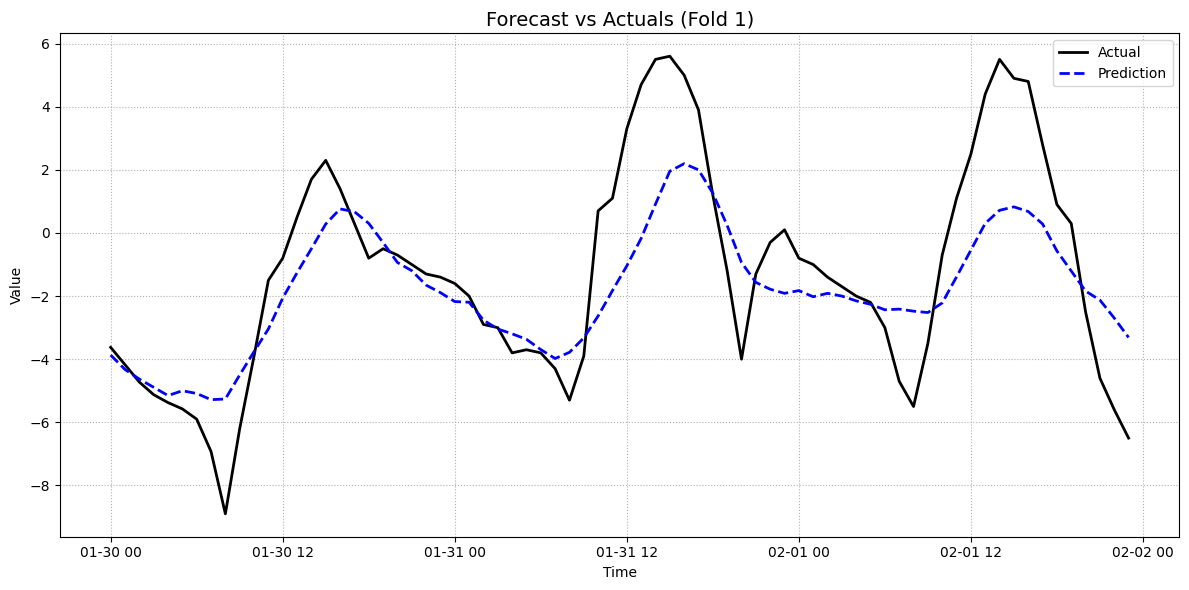

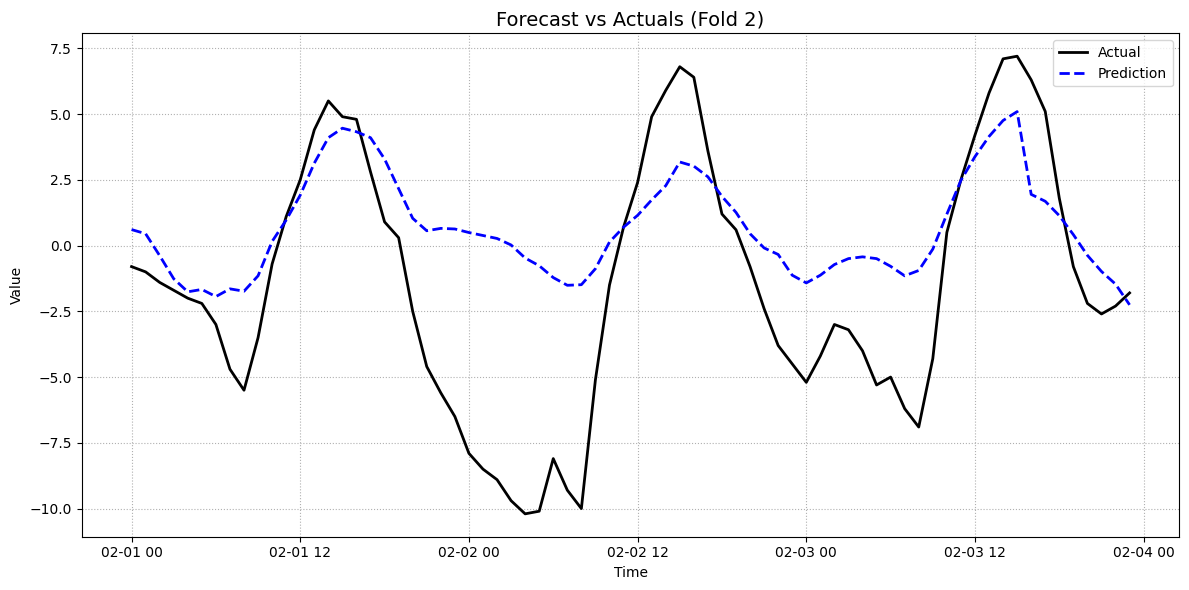

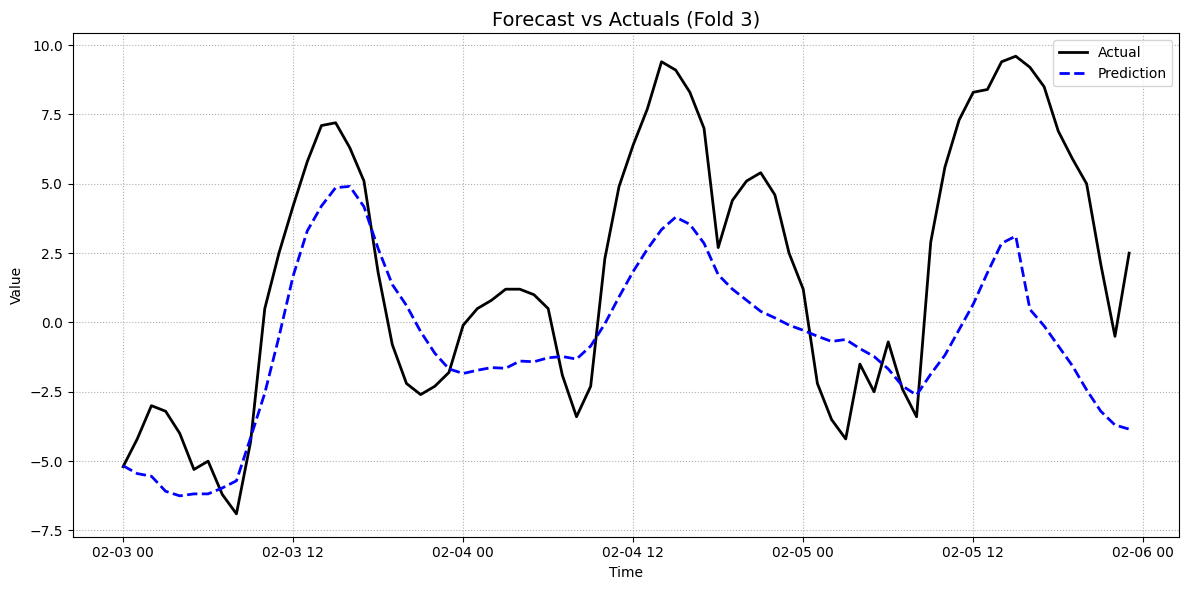

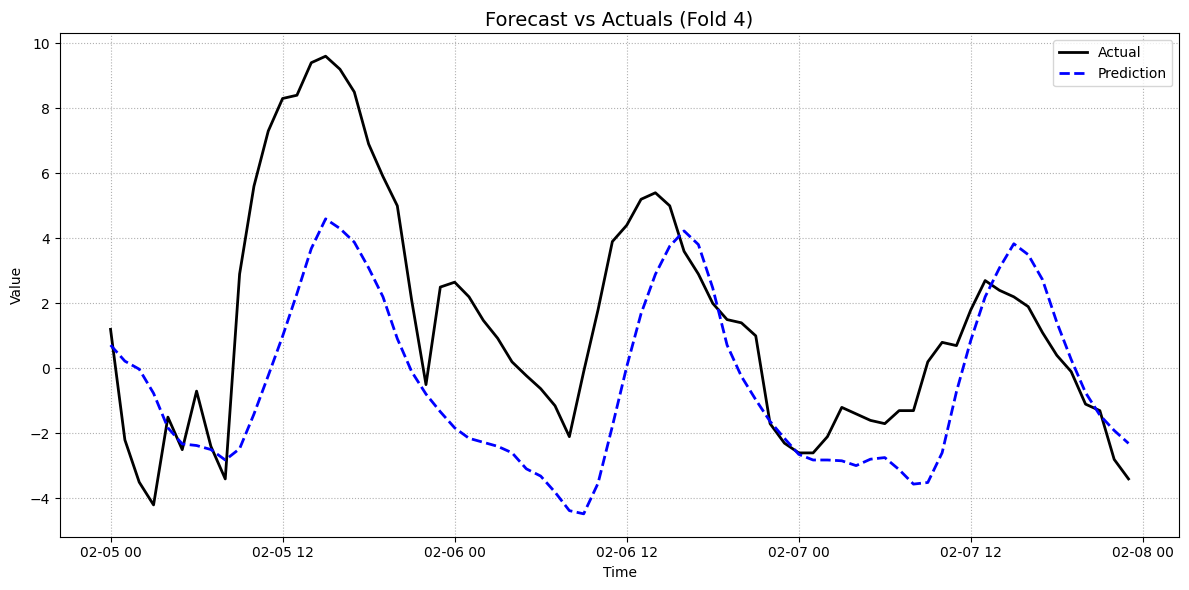

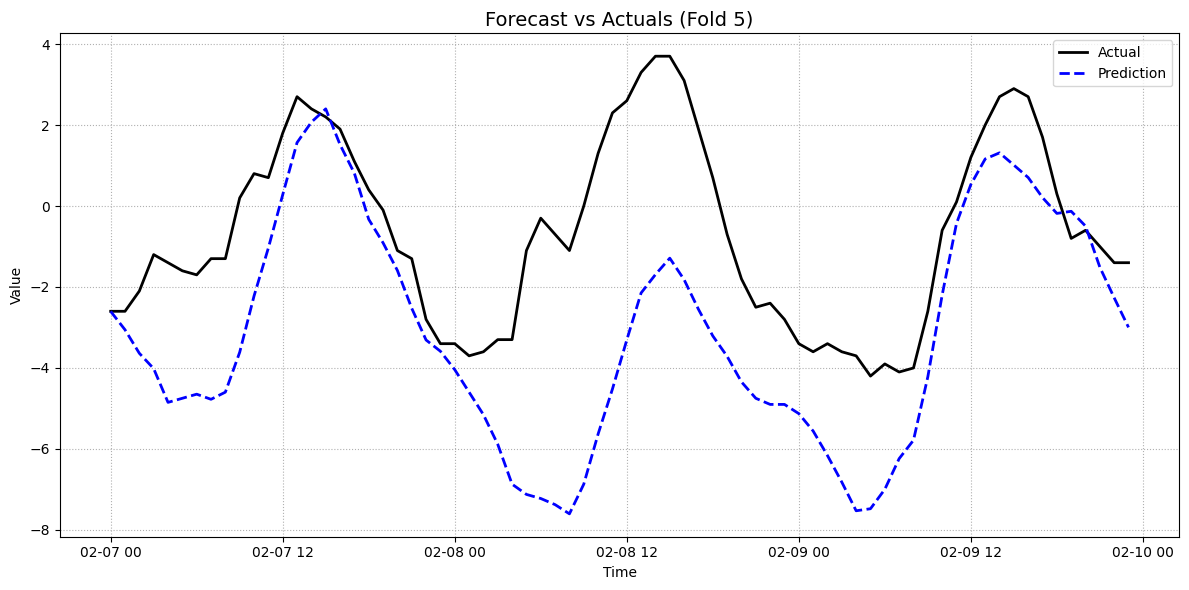

In [ ]:
results_df, all_predictions, all_actuals, _ = time_series_cv(
    pipeline,
    df,
    forecast_horizon,
    stride,
    start_date,
    end_date
)

#### Result per Fold

In [ ]:
results_df

,Date,RMSE,MAE,MAPE
0,2017-01-30,2.084248,1.551869,1.086027e+02
1,2017-02-01,4.072832,3.079794,8.183049e+01
2,2017-02-03,3.966600,3.223805,1.341271e+02
3,2017-02-05,3.140373,2.456239,2.252769e+02
4,2017-02-07,3.190561,2.513412,9.542086e+08
5,2017-02-09,3.234844,2.331798,1.615438e+02
6,2017-02-11,4.981130,3.777100,9.101245e+01
7,2017-02-13,2.753770,2.301794,4.172294e+07
8,2017-02-15,6.641605,5.605089,2.161954e+02
9,2017-02-17,4.035464,3.289534,1.826176e+02


#### CV Score Summary

In [ ]:
summary_df = summarize_cv_results(results_df)
summary_df

,mean,std,min,max
RMSE,4.028033e+00,1.465181e+00,2.084248,6.960599e+00
MAE,3.223630e+00,1.306459e+00,1.551869,6.106695e+00
MAPE,9.160992e+07,2.539145e+08,81.830488,9.542086e+08


### PARAMETER TUNING

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "temperature": [0.1, 0.5, 1.0, 1.5],  # Controls randomness in the predictions
    "top_k": [10, 30, 50, 100],          # Number of top predictions to consider
    "top_p": [0.1, 0.5, 0.75, 1.0],      # Cumulative probability for sampling predictions
    "num_samples": [5, 10, 20, 50]        # Number of samples to draw for each prediction
}

In [ ]:
# Generate all possible combinations of hyperparameters from the grid
param_combinations = list(ParameterGrid(param_grid))

In [ ]:
# Sample a subset of N combinations from the generated list
random.seed(1502)  # Set seed for reproducibility
sampled_combinations = random.sample(param_combinations, 10)  # Sample 10 combinations

sampled_combinations

[{'num_samples': 10, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.75},
 {'num_samples': 50, 'temperature': 1.5, 'top_k': 30, 'top_p': 0.5},
 {'num_samples': 20, 'temperature': 0.1, 'top_k': 30, 'top_p': 1.0},
 {'num_samples': 50, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.1},
 {'num_samples': 20, 'temperature': 1.5, 'top_k': 10, 'top_p': 1.0},
 {'num_samples': 5, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.1},
 {'num_samples': 50, 'temperature': 1.0, 'top_k': 10, 'top_p': 0.1},
 {'num_samples': 20, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.75},
 {'num_samples': 5, 'temperature': 1.5, 'top_k': 50, 'top_p': 0.75},
 {'num_samples': 50, 'temperature': 1.0, 'top_k': 100, 'top_p': 1.0}]

In [ ]:
def time_series_cv_tuning(
    pipeline,
    df,
    forecast_horizon,
    stride,
    start_date,
    end_date,
    params,
    metric="rmse"
):
    """
    Cross-validation for time series with flexible metric tuning.

    Parameters
    ----------
    pipeline : ChronosPipeline
        Pretrained Chronos model.
    df : pd.DataFrame or pd.Series
        Time series data with datetime index.
    forecast_horizon : int
        Number of steps ahead to forecast.
    stride : int
        Step size in hours for rolling window.
    start_date : datetime
        Start of CV window.
    end_date : datetime
        End of CV window.
    params : dict
        Parameters for pipeline.predict.
    metric : {"rmse", "mae", "mape"}, default="rmse"
        Which metric to optimize / report as main score.

    Returns
    -------
    results_df : pd.DataFrame
        DataFrame with metrics for each fold.
    all_predictions : list of np.ndarray
        Forecasts for each fold.
    all_actuals : list of np.ndarray
        Ground truth values.
    """

    results = []
    all_predictions = []
    all_actuals = []

    current_date = start_date
    fold = 0

    while current_date + pd.Timedelta(hours=forecast_horizon) <= end_date:
        # Train/test split
        train = df[df.index < current_date]
        test = df[current_date : current_date + pd.Timedelta(hours=forecast_horizon - 1)]

        # Forecast
        forecast = pipeline.predict(
            context=torch.tensor(train.values),
            temperature=params.get("temperature", 1.0),
            top_k=params.get("top_k", 50),
            top_p=params.get("top_p", 1.0),
            prediction_length=forecast_horizon,
            num_samples=params.get("num_samples", 20),
            limit_prediction_length=False
        )
        forecast_mean = torch.mean(torch.stack([f[0] for f in forecast]), dim=0)

        # Store predictions & actuals
        preds = forecast_mean.numpy()
        actuals = test.values.flatten()
        all_predictions.append(preds)
        all_actuals.append(actuals)

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = mean_absolute_error(actuals, preds)
        mape = np.mean(np.abs((actuals - preds) / np.where(actuals == 0, 1e-8, actuals))) * 100

        # Pick main metric for optimization
        if metric.lower() == "rmse":
            score = rmse
        elif metric.lower() == "mae":
            score = mae
        elif metric.lower() == "mape":
            score = mape
        else:
            raise ValueError("Invalid metric. Choose from 'rmse', 'mae', 'mape'.")

        print(
            f"Fold {fold+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.2f}% | Optimizing for {metric.upper()} = {score:.4f}"
        )

        results.append((current_date, rmse, mae, mape, score))
        fold += 1

        # Move forward
        current_date += pd.Timedelta(hours=stride)

    # Convert to DataFrame
    results_df = pd.DataFrame(
        results, columns=["Date", "RMSE", "MAE", "MAPE", f"{metric.upper()}_Score"]
    )

    return results_df, all_predictions, all_actuals


In [ ]:
# Initialize a list to store results
tuning_results = []

# Choose which metric to optimize ("rmse", "mae", or "mape")
opt_metric = "rmse"

for params in sampled_combinations:
    # Perform cross-validation with the current set of parameters
    results_df, _, _ = time_series_cv_tuning(
        pipeline,
        df,
        forecast_horizon,
        stride,
        start_date,
        end_date,
        params,
        metric=opt_metric
    )

    # Calculate and store the mean score for the chosen metric
    mean_score = results_df[f"{opt_metric.upper()}_Score"].mean()
    tuning_results.append({**params, opt_metric: mean_score})

    # Print the score for the current parameter set
    print(f"{opt_metric.upper()} for {params}: {mean_score:.4f}")

Fold 1: RMSE=2.7115, MAE=2.2307, MAPE=166.29% | Optimizing for RMSE = 2.7115


Fold 2: RMSE=3.3984, MAE=2.5865, MAPE=71.72% | Optimizing for RMSE = 3.3984


Fold 3: RMSE=5.9640, MAE=5.0395, MAPE=245.30% | Optimizing for RMSE = 5.9640


Fold 4: RMSE=3.2132, MAE=2.7778, MAPE=234.71% | Optimizing for RMSE = 3.2132


Fold 5: RMSE=1.8233, MAE=1.4927, MAPE=245568457.43% | Optimizing for RMSE = 1.8233


Fold 6: RMSE=4.1370, MAE=2.9831, MAPE=217.50% | Optimizing for RMSE = 4.1370


Fold 7: RMSE=5.0822, MAE=4.2177, MAPE=150.24% | Optimizing for RMSE = 5.0822


Fold 8: RMSE=2.9323, MAE=2.4062, MAPE=27815312.04% | Optimizing for RMSE = 2.9323


Fold 9: RMSE=4.8183, MAE=4.0493, MAPE=107.80% | Optimizing for RMSE = 4.8183


Fold 10: RMSE=3.8455, MAE=3.0544, MAPE=97.37% | Optimizing for RMSE = 3.8455


Fold 11: RMSE=2.9268, MAE=2.2876, MAPE=133.16% | Optimizing for RMSE = 2.9268


Fold 12: RMSE=3.0131, MAE=2.4927, MAPE=139571087.98% | Optimizing for RMSE = 3.0131


Fold 13: RMSE=5.4233, MAE=4.1658, MAPE=56541129.31% | Optimizing for RMSE = 5.4233


Fold 14: RMSE=5.1188, MAE=4.1279, MAPE=101.16% | Optimizing for RMSE = 5.1188
RMSE for {'num_samples': 10, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.75}: 3.8863


Fold 1: RMSE=2.1947, MAE=1.7600, MAPE=102.42% | Optimizing for RMSE = 2.1947


Fold 2: RMSE=3.2033, MAE=2.4960, MAPE=79.26% | Optimizing for RMSE = 3.2033


Fold 3: RMSE=5.3981, MAE=4.6116, MAPE=221.61% | Optimizing for RMSE = 5.3981


Fold 4: RMSE=4.1251, MAE=3.6156, MAPE=331.14% | Optimizing for RMSE = 4.1251


Fold 5: RMSE=1.9055, MAE=1.4309, MAPE=582347935.43% | Optimizing for RMSE = 1.9055


Fold 6: RMSE=3.9391, MAE=2.9624, MAPE=247.58% | Optimizing for RMSE = 3.9391


Fold 7: RMSE=4.7398, MAE=3.8873, MAPE=128.97% | Optimizing for RMSE = 4.7398


Fold 8: RMSE=2.9100, MAE=2.4704, MAPE=236429512.72% | Optimizing for RMSE = 2.9100


Fold 9: RMSE=3.4648, MAE=2.9639, MAPE=109.15% | Optimizing for RMSE = 3.4648


Fold 10: RMSE=3.9621, MAE=3.1466, MAPE=103.14% | Optimizing for RMSE = 3.9621


Fold 11: RMSE=3.0533, MAE=2.4486, MAPE=155.98% | Optimizing for RMSE = 3.0533


Fold 12: RMSE=2.7893, MAE=2.2655, MAPE=463979227.49% | Optimizing for RMSE = 2.7893


Fold 13: RMSE=5.6310, MAE=4.5528, MAPE=56541138.11% | Optimizing for RMSE = 5.6310


Fold 14: RMSE=5.8154, MAE=4.5412, MAPE=112.73% | Optimizing for RMSE = 5.8154
RMSE for {'num_samples': 50, 'temperature': 1.5, 'top_k': 30, 'top_p': 0.5}: 3.7951


Fold 1: RMSE=2.7991, MAE=2.2217, MAPE=168.80% | Optimizing for RMSE = 2.7991


Fold 2: RMSE=4.0604, MAE=3.1319, MAPE=85.29% | Optimizing for RMSE = 4.0604


Fold 3: RMSE=5.6023, MAE=4.8444, MAPE=237.85% | Optimizing for RMSE = 5.6023


Fold 4: RMSE=4.3144, MAE=3.7780, MAPE=336.26% | Optimizing for RMSE = 4.3144


Fold 5: RMSE=2.1872, MAE=1.6534, MAPE=627953525.79% | Optimizing for RMSE = 2.1872


Fold 6: RMSE=3.7854, MAE=2.8040, MAPE=200.50% | Optimizing for RMSE = 3.7854


Fold 7: RMSE=6.6746, MAE=5.1428, MAPE=149.76% | Optimizing for RMSE = 6.6746


Fold 8: RMSE=3.7907, MAE=3.1193, MAPE=111261028.52% | Optimizing for RMSE = 3.7907


Fold 9: RMSE=3.1221, MAE=2.7246, MAPE=82.09% | Optimizing for RMSE = 3.1221


Fold 10: RMSE=4.7931, MAE=3.9132, MAPE=110.76% | Optimizing for RMSE = 4.7931


Fold 11: RMSE=3.0005, MAE=2.5060, MAPE=165.12% | Optimizing for RMSE = 3.0005


Fold 12: RMSE=3.5703, MAE=2.8418, MAPE=82988335.81% | Optimizing for RMSE = 3.5703


Fold 13: RMSE=5.0831, MAE=3.7748, MAPE=56541124.73% | Optimizing for RMSE = 5.0831


Fold 14: RMSE=6.0125, MAE=4.9944, MAPE=142.25% | Optimizing for RMSE = 6.0125
RMSE for {'num_samples': 20, 'temperature': 0.1, 'top_k': 30, 'top_p': 1.0}: 4.1997


Fold 1: RMSE=2.7580, MAE=2.2312, MAPE=171.22% | Optimizing for RMSE = 2.7580


Fold 2: RMSE=3.7925, MAE=2.9841, MAPE=93.27% | Optimizing for RMSE = 3.7925


Fold 3: RMSE=6.5345, MAE=5.7875, MAPE=295.70% | Optimizing for RMSE = 6.5345


Fold 4: RMSE=3.8111, MAE=3.1521, MAPE=275.22% | Optimizing for RMSE = 3.8111


Fold 5: RMSE=2.1193, MAE=1.6915, MAPE=554282995.38% | Optimizing for RMSE = 2.1193


Fold 6: RMSE=4.0676, MAE=3.1680, MAPE=262.67% | Optimizing for RMSE = 4.0676


Fold 7: RMSE=5.9404, MAE=4.8080, MAPE=121.91% | Optimizing for RMSE = 5.9404


Fold 8: RMSE=3.7404, MAE=3.1175, MAPE=111261030.54% | Optimizing for RMSE = 3.7404


Fold 9: RMSE=3.9101, MAE=3.2720, MAPE=87.48% | Optimizing for RMSE = 3.9101


Fold 10: RMSE=4.1323, MAE=3.3189, MAPE=101.84% | Optimizing for RMSE = 4.1323


Fold 11: RMSE=2.9335, MAE=2.4188, MAPE=158.19% | Optimizing for RMSE = 2.9335


Fold 12: RMSE=3.0676, MAE=2.5755, MAPE=82988272.41% | Optimizing for RMSE = 3.0676


Fold 13: RMSE=5.5668, MAE=4.3279, MAPE=56541130.43% | Optimizing for RMSE = 5.5668


Fold 14: RMSE=8.3857, MAE=6.7421, MAPE=115.71% | Optimizing for RMSE = 8.3857
RMSE for {'num_samples': 50, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.1}: 4.3400


Fold 1: RMSE=2.7282, MAE=2.2110, MAPE=182.84% | Optimizing for RMSE = 2.7282


Fold 2: RMSE=3.7433, MAE=2.8724, MAPE=84.42% | Optimizing for RMSE = 3.7433


Fold 3: RMSE=7.0032, MAE=6.2236, MAPE=338.33% | Optimizing for RMSE = 7.0032


Fold 4: RMSE=3.6280, MAE=3.1160, MAPE=259.88% | Optimizing for RMSE = 3.6280


Fold 5: RMSE=1.5225, MAE=1.2794, MAPE=329763328.94% | Optimizing for RMSE = 1.5225


Fold 6: RMSE=4.3013, MAE=3.4308, MAPE=258.95% | Optimizing for RMSE = 4.3013


Fold 7: RMSE=4.5312, MAE=3.5404, MAPE=127.81% | Optimizing for RMSE = 4.5312


Fold 8: RMSE=3.2534, MAE=2.6398, MAPE=27815327.89% | Optimizing for RMSE = 3.2534


Fold 9: RMSE=3.4859, MAE=2.7882, MAPE=107.99% | Optimizing for RMSE = 3.4859


Fold 10: RMSE=3.8118, MAE=3.0756, MAPE=97.09% | Optimizing for RMSE = 3.8118


Fold 11: RMSE=3.4200, MAE=2.7093, MAPE=196.51% | Optimizing for RMSE = 3.4200


Fold 12: RMSE=2.5478, MAE=2.0734, MAPE=135798894.06% | Optimizing for RMSE = 2.5478


Fold 13: RMSE=5.7019, MAE=4.4245, MAPE=67849360.43% | Optimizing for RMSE = 5.7019


Fold 14: RMSE=4.5314, MAE=3.7028, MAPE=124.73% | Optimizing for RMSE = 4.5314
RMSE for {'num_samples': 20, 'temperature': 1.5, 'top_k': 10, 'top_p': 1.0}: 3.8721


Fold 1: RMSE=2.8674, MAE=2.3148, MAPE=179.30% | Optimizing for RMSE = 2.8674


Fold 2: RMSE=4.9700, MAE=4.1449, MAPE=97.16% | Optimizing for RMSE = 4.9700


Fold 3: RMSE=6.6830, MAE=5.8995, MAPE=303.42% | Optimizing for RMSE = 6.6830


Fold 4: RMSE=3.1160, MAE=2.6762, MAPE=218.86% | Optimizing for RMSE = 3.1160


Fold 5: RMSE=1.8705, MAE=1.4264, MAPE=491136844.84% | Optimizing for RMSE = 1.8705


Fold 6: RMSE=4.0317, MAE=2.9161, MAPE=209.59% | Optimizing for RMSE = 4.0317


Fold 7: RMSE=5.9404, MAE=4.8080, MAPE=121.91% | Optimizing for RMSE = 5.9404


Fold 8: RMSE=3.7404, MAE=3.1175, MAPE=111261030.54% | Optimizing for RMSE = 3.7404


Fold 9: RMSE=3.9101, MAE=3.2720, MAPE=87.48% | Optimizing for RMSE = 3.9101


Fold 10: RMSE=4.1323, MAE=3.3189, MAPE=101.84% | Optimizing for RMSE = 4.1323


Fold 11: RMSE=2.9259, MAE=2.4266, MAPE=173.03% | Optimizing for RMSE = 2.9259


Fold 12: RMSE=3.1732, MAE=2.6531, MAPE=82988273.77% | Optimizing for RMSE = 3.1732


Fold 13: RMSE=5.5668, MAE=4.3279, MAPE=56541130.43% | Optimizing for RMSE = 5.5668


Fold 14: RMSE=6.3070, MAE=5.2762, MAPE=136.70% | Optimizing for RMSE = 6.3070
RMSE for {'num_samples': 5, 'temperature': 0.5, 'top_k': 30, 'top_p': 0.1}: 4.2311


Fold 1: RMSE=2.9234, MAE=2.3643, MAPE=185.98% | Optimizing for RMSE = 2.9234


Fold 2: RMSE=3.8048, MAE=2.9150, MAPE=81.28% | Optimizing for RMSE = 3.8048


Fold 3: RMSE=6.6564, MAE=5.8369, MAPE=297.45% | Optimizing for RMSE = 6.6564


Fold 4: RMSE=2.9988, MAE=2.5288, MAPE=201.15% | Optimizing for RMSE = 2.9988


Fold 5: RMSE=1.8574, MAE=1.5936, MAPE=364844527.38% | Optimizing for RMSE = 1.8574


Fold 6: RMSE=4.6064, MAE=3.4425, MAPE=309.72% | Optimizing for RMSE = 4.6064


Fold 7: RMSE=5.9404, MAE=4.8080, MAPE=121.91% | Optimizing for RMSE = 5.9404


Fold 8: RMSE=3.7404, MAE=3.1175, MAPE=111261030.54% | Optimizing for RMSE = 3.7404


Fold 9: RMSE=3.9101, MAE=3.2720, MAPE=87.48% | Optimizing for RMSE = 3.9101


Fold 10: RMSE=4.1323, MAE=3.3189, MAPE=101.84% | Optimizing for RMSE = 4.1323


Fold 11: RMSE=2.9259, MAE=2.4266, MAPE=173.03% | Optimizing for RMSE = 2.9259


Fold 12: RMSE=3.1732, MAE=2.6531, MAPE=82988273.77% | Optimizing for RMSE = 3.1732


Fold 13: RMSE=5.5668, MAE=4.3279, MAPE=56541130.43% | Optimizing for RMSE = 5.5668


Fold 14: RMSE=6.0683, MAE=5.0078, MAPE=146.22% | Optimizing for RMSE = 6.0683
RMSE for {'num_samples': 50, 'temperature': 1.0, 'top_k': 10, 'top_p': 0.1}: 4.1646


Fold 1: RMSE=2.5064, MAE=2.0561, MAPE=147.60% | Optimizing for RMSE = 2.5064


Fold 2: RMSE=3.1431, MAE=2.4000, MAPE=78.59% | Optimizing for RMSE = 3.1431


Fold 3: RMSE=5.3626, MAE=4.4300, MAPE=215.50% | Optimizing for RMSE = 5.3626


Fold 4: RMSE=3.0378, MAE=2.5655, MAPE=234.28% | Optimizing for RMSE = 3.0378


Fold 5: RMSE=1.6626, MAE=1.3797, MAPE=354320198.16% | Optimizing for RMSE = 1.6626


Fold 6: RMSE=4.2719, MAE=3.1282, MAPE=256.02% | Optimizing for RMSE = 4.2719


Fold 7: RMSE=5.4837, MAE=4.5328, MAPE=128.55% | Optimizing for RMSE = 5.4837


Fold 8: RMSE=3.6478, MAE=2.8302, MAPE=69538157.61% | Optimizing for RMSE = 3.6478


Fold 9: RMSE=4.1801, MAE=3.5012, MAPE=91.47% | Optimizing for RMSE = 4.1801


Fold 10: RMSE=4.0329, MAE=3.2959, MAPE=131.44% | Optimizing for RMSE = 4.0329


Fold 11: RMSE=3.1475, MAE=2.5222, MAPE=170.73% | Optimizing for RMSE = 3.1475


Fold 12: RMSE=3.3073, MAE=2.7329, MAPE=82988309.87% | Optimizing for RMSE = 3.3073


Fold 13: RMSE=4.0894, MAE=3.1188, MAPE=67849361.22% | Optimizing for RMSE = 4.0894


Fold 14: RMSE=4.9498, MAE=4.0128, MAPE=125.79% | Optimizing for RMSE = 4.9498
RMSE for {'num_samples': 20, 'temperature': 0.5, 'top_k': 100, 'top_p': 0.75}: 3.7731


Fold 1: RMSE=2.3044, MAE=1.7985, MAPE=121.73% | Optimizing for RMSE = 2.3044


Fold 2: RMSE=3.6033, MAE=2.8766, MAPE=100.36% | Optimizing for RMSE = 3.6033


Fold 3: RMSE=6.1318, MAE=5.3678, MAPE=258.87% | Optimizing for RMSE = 6.1318


Fold 4: RMSE=2.5554, MAE=2.2103, MAPE=119.59% | Optimizing for RMSE = 2.5554


Fold 5: RMSE=3.9155, MAE=3.4966, MAPE=1066468581.92% | Optimizing for RMSE = 3.9155


Fold 6: RMSE=3.7333, MAE=2.6798, MAPE=240.64% | Optimizing for RMSE = 3.7333


Fold 7: RMSE=6.2635, MAE=5.2858, MAPE=202.45% | Optimizing for RMSE = 6.2635


Fold 8: RMSE=2.5463, MAE=2.0825, MAPE=292059960.80% | Optimizing for RMSE = 2.5463


Fold 9: RMSE=3.8816, MAE=3.0188, MAPE=144.29% | Optimizing for RMSE = 3.8816


Fold 10: RMSE=5.1533, MAE=4.2196, MAPE=228.85% | Optimizing for RMSE = 5.1533


Fold 11: RMSE=3.4431, MAE=2.6916, MAPE=149.21% | Optimizing for RMSE = 3.4431


Fold 12: RMSE=3.4100, MAE=2.9306, MAPE=482840210.17% | Optimizing for RMSE = 3.4100


Fold 13: RMSE=4.6412, MAE=3.7739, MAPE=98004642.90% | Optimizing for RMSE = 4.6412


Fold 14: RMSE=5.7294, MAE=4.7782, MAPE=102.56% | Optimizing for RMSE = 5.7294
RMSE for {'num_samples': 5, 'temperature': 1.5, 'top_k': 50, 'top_p': 0.75}: 4.0937


Fold 1: RMSE=2.4172, MAE=1.9605, MAPE=84.02% | Optimizing for RMSE = 2.4172


Fold 2: RMSE=3.8288, MAE=2.8066, MAPE=117.10% | Optimizing for RMSE = 3.8288


Fold 3: RMSE=4.4552, MAE=3.6755, MAPE=208.91% | Optimizing for RMSE = 4.4552


Fold 4: RMSE=5.2497, MAE=4.6118, MAPE=424.43% | Optimizing for RMSE = 5.2497


Fold 5: RMSE=2.1578, MAE=1.8348, MAPE=301698433.92% | Optimizing for RMSE = 2.1578


Fold 6: RMSE=4.3109, MAE=3.3148, MAPE=163.12% | Optimizing for RMSE = 4.3109


Fold 7: RMSE=5.9490, MAE=5.0748, MAPE=211.63% | Optimizing for RMSE = 5.9490


Fold 8: RMSE=3.3494, MAE=2.8222, MAPE=139076268.35% | Optimizing for RMSE = 3.3494


Fold 9: RMSE=3.7417, MAE=3.0489, MAPE=107.73% | Optimizing for RMSE = 3.7417


Fold 10: RMSE=2.7784, MAE=2.3351, MAPE=140.50% | Optimizing for RMSE = 2.7784


Fold 11: RMSE=3.2686, MAE=2.5882, MAPE=263.10% | Optimizing for RMSE = 3.2686


Fold 12: RMSE=3.6700, MAE=3.0732, MAPE=490384582.94% | Optimizing for RMSE = 3.6700


Fold 13: RMSE=4.7363, MAE=3.6503, MAPE=41463529.27% | Optimizing for RMSE = 4.7363
Fold 14: RMSE=3.8861, MAE=2.9756, MAPE=184.97% | Optimizing for RMSE = 3.8861
RMSE for {'num_samples': 50, 'temperature': 1.0, 'top_k': 100, 'top_p': 1.0}: 3.8428


#### Tuning Results

In [ ]:
# Put the results into a DataFrame
tuning_df = pd.DataFrame(tuning_results)
tuning_df


,num_samples,temperature,top_k,top_p,rmse
0,10,0.5,30,0.75,3.886270
1,50,1.5,30,0.50,3.795117
2,20,0.1,30,1.00,4.199692
3,50,0.5,100,0.10,4.339990
4,20,1.5,10,1.00,3.872143
5,5,0.5,30,0.10,4.231059
6,50,1.0,10,0.10,4.164624
7,20,0.5,100,0.75,3.773065
8,5,1.5,50,0.75,4.093733
9,50,1.0,100,1.00,3.842794


#### Best Parameters

In [ ]:
# Identify the best parameter set based on the chosen metric
best_params = tuning_df.sort_values(opt_metric).iloc[0]

# Export the best parameters to a CSV file
best_params.to_csv('best_params.csv')


In [ ]:
# Transform the best parameters into a dictionary
best_params_dict = best_params.squeeze().to_dict()
best_params_dict

{'num_samples': 20.0,
 'temperature': 0.5,
 'top_k': 100.0,
 'top_p': 0.75,
 'rmse': 3.7730654100678085}

**Best Parameters:**
- 'num_samples': 20.0,
- 'temperature': 0.5,
- 'top_k': 100.0,
- 'top_p': 0.75,
-  'rmse': 3.7730654100678085

### PREDICT THE FUTURE

In [ ]:
# Build the tuned amazon chronos model
best_forecast = pipeline.predict(
    context = torch.tensor(df.values),                    # Provide the entire dataset as context for prediction
    temperature = best_params_dict['temperature'],        # Set the temperature parameter for sampling
    top_k = int(best_params_dict['top_k']),               # Use the top_k parameter to control diversity of predictions
    top_p = best_params_dict['top_p'],                    # Use the top_p parameter to control cumulative probability for sampling
    prediction_length = forecast_horizon,                 # Specify the number of steps to forecast
    num_samples = int(best_params_dict['num_samples']),   # Define the number of samples for predictions
    limit_prediction_length = False)                      # Allow predictions to exceed the default limit if set to False

In [ ]:
# Compute the mean of the forecast across all num_samples
best_forecast_mean = torch.mean(torch.stack([f[0] for f in best_forecast]), dim = 0)

# Create an index for the forecast that starts immediately after the last index in the df
forecast_index = pd.date_range(start = df.index[-1] + pd.Timedelta(hours = 1),
                               periods = forecast_horizon,
                               freq = "h")

# Create a Pandas Series with the forecast values and index
forecast_series = pd.Series(
    best_forecast_mean.numpy(),   # Convert the tensor to a NumPy array
    index=forecast_index)         # Use the generated forecast index

# Rename the series for clarity
forecast_series = forecast_series.rename("Amazon Chronos")

forecast_series[:2]

,Amazon Chronos
2017-03-01 00:00:00,5.690217
2017-03-01 01:00:00,4.309751


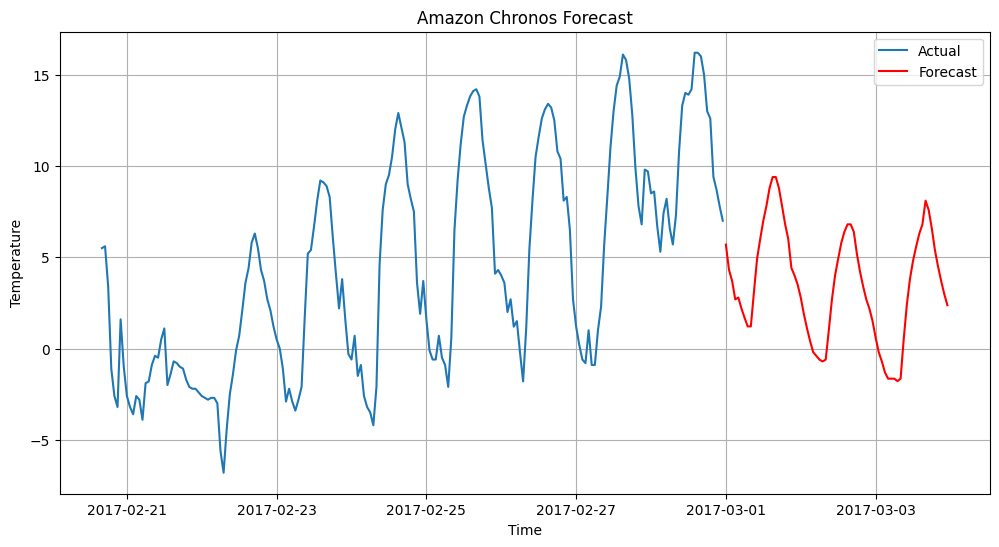

In [ ]:
# Plot the df with the forecast
plt.figure(figsize = (12, 6))

# Actual values
plt.plot(df[-200:], label = "Actual")
# Forecast values
plt.plot(forecast_series, label = "Forecast", color = "red")

# Set title, legend, and labels
plt.title("Amazon Chronos Forecast")
plt.ylabel("Temperature")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()